 ```
                                                                    .___ ______________________  _________________
                                                                    |   |\__    ___/\_   _____/ /   _____/\_____  \
                                                                    |   |  |    |    |    __)_  \_____  \  /   |   \
                                                                    |   |  |    |    |        \ /        \/    |    \
                                                                    |___|  |____|   /_______  //_______  /\_______  /
                                                                                            \/         \/         \/
```
<div class="alert alert-block alert-info">
<span style="color: rgb(0,53,91);">
<center><img src="https://pbs.twimg.com/profile_images/1543728120066215936/kZrRvZC9_400x400.jpg" height ="50"><center>
<font face = "Times New Roman" size = "6"><b><center>Programacion para Mineria de Datos</center></b></font>
<font face = "Times New Roman" size = "5"><b><center>EJERCICIO_ESCALAMIENTO_DATOS</center></b></font>

<b><font back = "Times New Roman" size = "4"><center>Proyecto </center></font>

<div align="right"><font face = "Times New Roman" size = "2">Mtro. Miguel Tlapa Juarez (migueltlapa@iteso.mx)</font></div>
<div align="right"><font face = "Times New Roman" size = "2">Sofía Vanessa Noyola Fonseca (sofia.noyola@iteso.mx)</font></div>
<div align="right"><font face = "Times New Roman" size = "2">Sebastian Garcia-Moreno Zinchenko (zinchenko@iteso.mx)</font></div>
<div align="right"><font face = "Times New Roman" size = "2">Francsico Javier Ramos Jimenez(javier.ramos@iteso.mx)</font></div>


</span></div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
#############################################
#############################################

df = pd.read_csv("../../00_Data_Clean/00_Data_Clean/retail_store_inventory_entrenamiento.csv")

#############################################
#############################################

df.columns

Index(['Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level',
       'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount',
       'Holiday/Promotion', 'Competitor Pricing', 'Seasonality',
       'date_timestamp'],
      dtype='object')

In [3]:
df.head()

,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Seasonality,date_timestamp
0,1,1,groceries,north,231,127.0,55.0,135.47,33.50,20,0,29.69,autumn,1640995200
1,1,2,toys,south,204,150.0,66.0,144.04,63.01,20,0,66.16,autumn,1640995200
2,1,3,toys,west,102,65.0,51.0,74.02,27.99,10,1,31.32,summer,1640995200
3,1,4,toys,north,469,61.0,164.0,62.18,32.72,10,1,34.74,autumn,1640995200
4,1,5,electronics,east,166,14.0,135.0,9.26,73.64,0,0,68.95,summer,1640995200


In [4]:
df.dtypes

Store ID                int64
Product ID              int64
Category               object
Region                 object
Inventory Level         int64
Units Sold            float64
Units Ordered         float64
Demand Forecast       float64
Price                 float64
Discount                int64
Holiday/Promotion       int64
Competitor Pricing    float64
Seasonality            object
date_timestamp          int64
dtype: object

##### Separar datos entrenamiento y prueba

In [5]:
#######################################################
#######################################################
y = df['Demand Forecast']
X = df.drop(columns=['Demand Forecast'])
#######################################################
#######################################################

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, shuffle=True
)

print("Shapes -> X_train:", X_train.shape, " | X_test:", X_test.shape)

Shapes -> X_train: (54750, 13)  | X_test: (18250, 13)


##### Separar columnas categoricas y númericas.

In [6]:
#################################################################
"""
'Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level',
       'Units Sold', 'Units Ordered', 'Price', 'Discount',
       'Holiday/Promotion', 'Competitor Pricing', 'Seasonality',
       'date_timestamp'
"""
cols_num = ['Store ID', 'Product ID','Inventory Level','Units Sold', 'Units Ordered', 'Price', 'Discount','Competitor Pricing','date_timestamp']
cols_cat = ['Category', 'Region','Holiday/Promotion','Seasonality']
#################################################################
X_train_num = X_train[cols_num]
X_train_cat = X_train[cols_cat]
X_test_num = X_test[cols_num]
X_test_cat = X_test[cols_cat]

In [7]:
X_train_cat

,Category,Region,Holiday/Promotion,Seasonality
17384,electronics,west,1,spring
16914,furniture,east,1,summer
69115,groceries,west,0,winter
37744,furniture,south,1,autumn
1480,groceries,west,0,spring
...,...,...,...,...
21243,toys,south,1,summer
45891,furniture,north,1,spring
42613,electronics,north,0,spring
43567,clothing,south,1,summer


##### Usaremos One hot para todas debido a que no existe jerarquía

In [8]:
for col in X_train_cat.columns:
    print(col, X_train_cat[col].unique())

Category ['electronics' 'furniture' 'groceries' 'toys' 'clothing']
Region ['west' 'east' 'south' 'north']
Holiday/Promotion [1 0]
Seasonality ['spring' 'summer' 'winter' 'autumn']


In [9]:
########## codificado de columnas categoricas
# Nota este paso depende de EXPERIENCIA
####################################################################
cols_onehot  = ['Category','Region','Holiday/Promotion','Seasonality']      #NOMINALES -> One Hot
cols_ordinal = [] #ORDINALES -> Ordinal

# Categorías ordenadas para las ordinales (mismo orden que en cols_ordinal)
categorias_ordinales = [['toys', 'groceries', 'clothing', 'electronics', 'furniture'],['west', 'south', 'north','east'],[1,0],['autumn', 'winter', 'summer', 'spring']]# lista de listas
####################################################################
preprocessor_cat = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(sparse_output=False, drop=None, handle_unknown="ignore"), cols_onehot),
        ("ordinal", OrdinalEncoder(categories=categorias_ordinales, handle_unknown="use_encoded_value", unknown_value=-1), cols_ordinal),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

preprocessor_cat.fit(X_train_cat)

X_train_cat_proc = preprocessor_cat.transform(X_train_cat)
X_test_cat_proc = preprocessor_cat.transform(X_test_cat)

# -----------------------------------------
# Renombrar One-Hot a formato col___categoria
# -----------------------------------------
onehot = preprocessor_cat.named_transformers_.get("onehot")

rename_map = {}
if onehot is not None and len(cols_onehot) > 0:
    for col, cats in zip(cols_onehot, onehot.categories_):
        for cat in cats:
            old = f"{col}_{cat}"      # nombre que entrega sklearn con verbose_feature_names_out=False
            new = f"{col}___{cat}"    # triple guion bajo deseado
            rename_map[old] = new

# Obtener nombres del ColumnTransformer y aplicar renombres solo a OHE
cols_out_cat = preprocessor_cat.get_feature_names_out()
cols_out_cat = [rename_map.get(c, c) for c in cols_out_cat]

# Reconstruir DataFrames con índices originales
df_train_cat_encode = pd.DataFrame(X_train_cat_proc, columns=cols_out_cat, index=X_train_cat.index)
df_test_cat_encode  = pd.DataFrame(X_test_cat_proc,  columns=cols_out_cat, index=X_test_cat.index)

In [10]:
df_test_cat_encode.head(15)

,Category___clothing,Category___electronics,Category___furniture,Category___groceries,Category___toys,Region___east,Region___north,Region___south,Region___west,Holiday/Promotion___0,Holiday/Promotion___1,Seasonality___autumn,Seasonality___spring,Seasonality___summer,Seasonality___winter
38645,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
23731,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
24126,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3674,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3060,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3485,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
63249,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
10266,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
32512,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
29803,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


##### Realizamos el diagnostico de columnas

Columnas numéricas: ['Store ID', 'Product ID', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Competitor Pricing', 'date_timestamp']

=== Diagnóstico numérico (heurística) ===

              columna  missing_%   skew  kurtosis  outliers_n  outliers_%  \
3          Units Sold       2.99  0.903     0.050         507        0.95   
4       Units Ordered       2.97  0.004    -1.203           0        0.00   
0            Store ID       0.00 -0.000    -1.303           0        0.00   
1          Product ID       0.00  0.001    -1.207           0        0.00   
2     Inventory Level       0.00  0.012    -1.201           0        0.00   
5               Price       0.00 -0.001    -1.197           0        0.00   
6            Discount       0.00  0.001    -1.305           0        0.00   
7  Competitor Pricing       0.00 -0.002    -1.168           0        0.00   
8      date_timestamp       0.00  0.005    -1.202           0        0.00   

             q1            

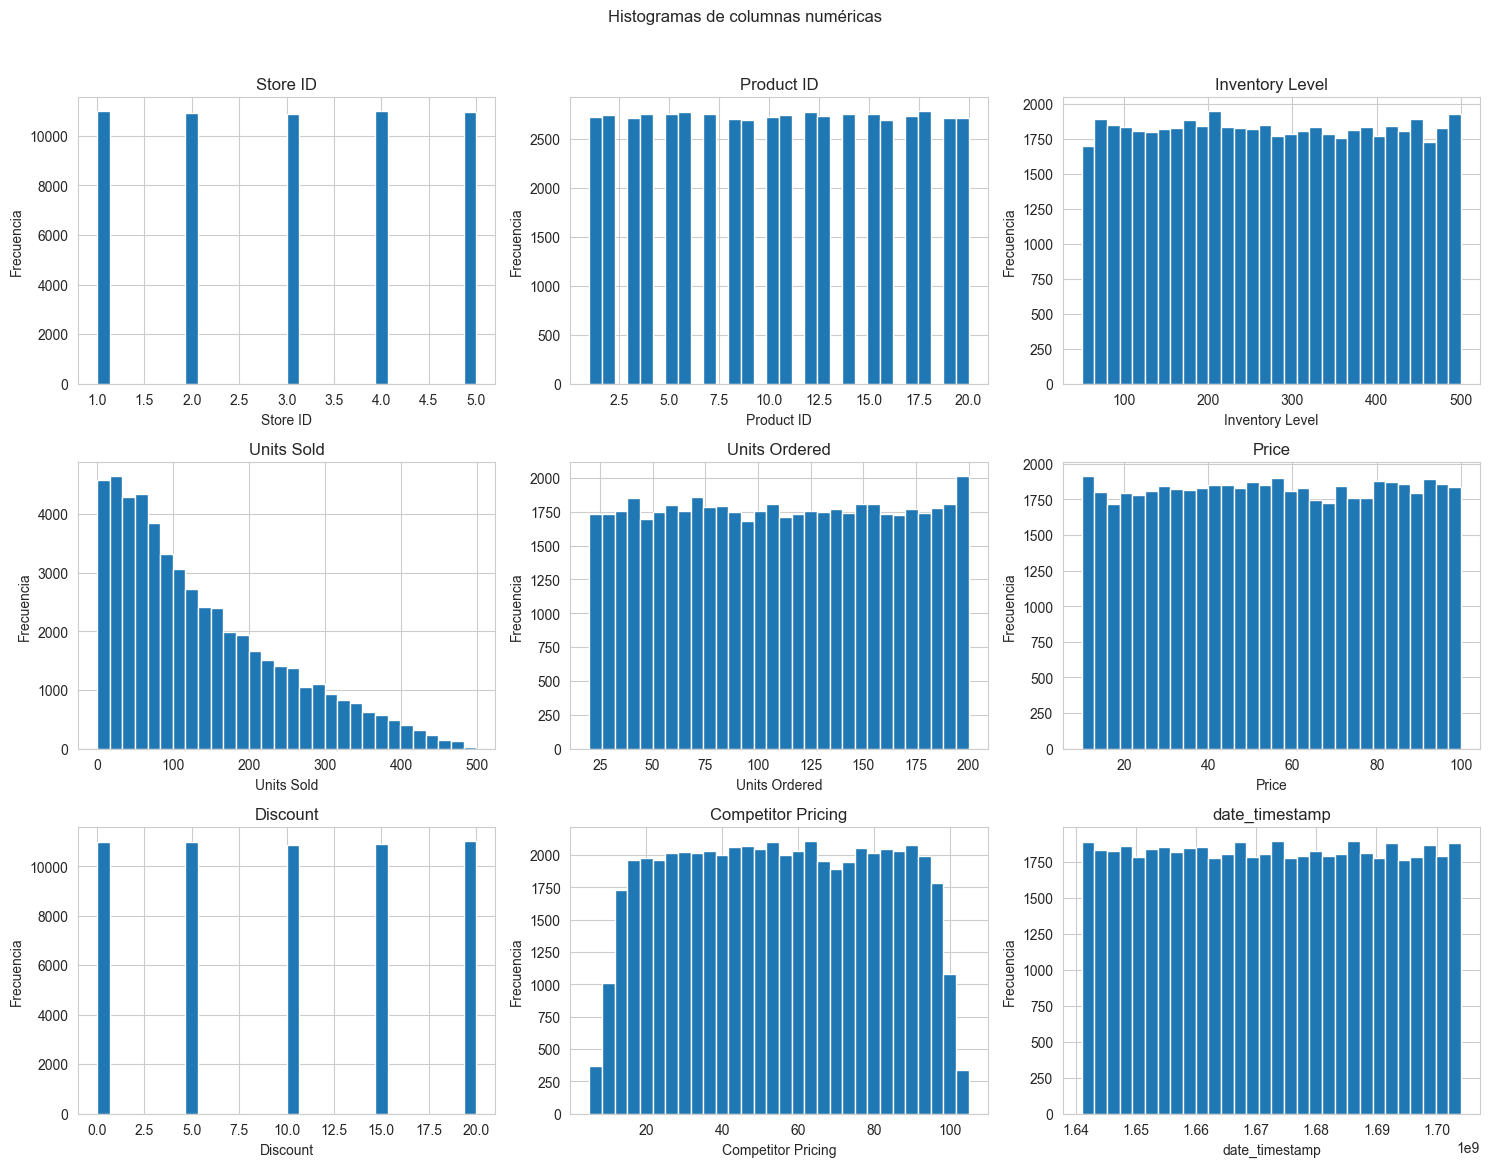

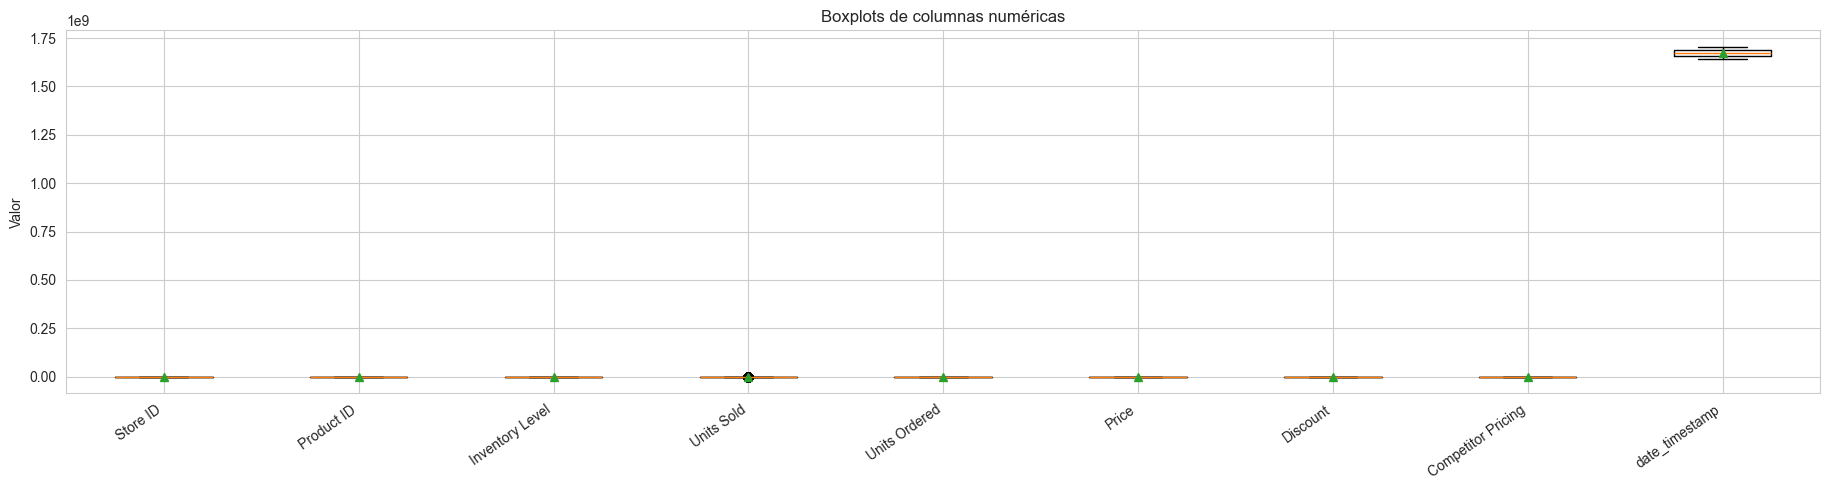

In [11]:
###########################
########################### DIAGNÓSTICO DE COLUMNAS
###########################


# 1) Detecta numéricas
print("Columnas numéricas:", cols_num)

# 2) Funciones auxiliares
def iqr_outlier_stats(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0, 0.0, np.nan, np.nan, np.nan, np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lim_inf, lim_sup = q1 - 1.5*iqr, q3 + 1.5*iqr
    n_out = int(((s < lim_inf) | (s > lim_sup)).sum())
    prop_out = n_out / len(s)
    return n_out, prop_out, q1, q3, lim_inf, lim_sup

def bounded_guess(s: pd.Series):
    """Detecta si parece estar acotada en [0,1] o [0,100]."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return None
    mn, mx = float(s.min()), float(s.max())
    if 0.0 <= mn and mx <= 1.0:
        return "[0,1]"
    if 0.0 <= mn and mx <= 100.0:
        return "[0,100]"
    return None

if len(cols_num) == 0:
    print("No hay columnas numéricas en X_train. No se generan imágenes.")
else:
    # --------- Figura 1: HISTOGRAMAS (todos en subplots) ----------
    n = len(cols_num)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols_num):
        s = pd.to_numeric(X_train[col], errors="coerce").dropna()
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.hist(s, bins=30)
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")

    # Oculta subplots sobrantes
    for j in range(len(cols_num), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas de columnas numéricas", y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig("histogramas_numericas.png", dpi=150, bbox_inches="tight")
   # plt.close(fig)

    # --------- Figura 2: BOXPLOTS (todas en un eje) ----------
    series_pairs = []
    for c in cols_num:
        v = pd.to_numeric(X_train[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos numéricos válidos para boxplots. No se genera boxplot.")
        box_path = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6*len(labels)+4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots de columnas numéricas")
        plt.tight_layout()
        fig2.savefig("boxplots_numericas.png", dpi=150, bbox_inches="tight")
       # plt.close(fig2)


# ================================
# Diagnóstico numérico + heurística
# ================================
diagnostico = []
for c in cols_num:
    s = pd.to_numeric(X_train[c], errors="coerce")
    miss_pct = s.isna().mean() * 100
    s_no_na = s.dropna()
    skew = s_no_na.skew() if s_no_na.size > 1 else np.nan
    kurt = s_no_na.kurt() if s_no_na.size > 1 else np.nan
    n_out, prop_out, q1, q3, li, ls = iqr_outlier_stats(s)
    bounds = bounded_guess(s)


    # Heurística de imputación
    if (prop_out >= 0.05) or (pd.notna(skew) and abs(skew) >= 1.0):
        imputador = "median"
    else:
        imputador = "mean"

    # Heurística de escalado
    if prop_out >= 0.05:
        escalador = "RobustScaler"
    elif pd.notna(skew) and abs(skew) <= 0.5:
        escalador = "StandardScaler"
    else:
        escalador = "MinMaxScaler"  # por defecto en casos no normales o acotados

    diagnostico.append({
        "columna": c,
        "missing_%": round(miss_pct, 2),
        "skew": round(skew, 3) if pd.notna(skew) else np.nan,
        "kurtosis": round(kurt, 3) if pd.notna(kurt) else np.nan,
        "outliers_n": n_out,
        "outliers_%": round(prop_out*100, 2),
        "q1": q1, "q3": q3, "IQR": (q3 - q1),
        "lim_inf": li, "lim_sup": ls,
        "bounded": bounds,
        "recom_imputer": imputador,
        "recom_scaler": escalador,
    })

diag_df = pd.DataFrame(diagnostico).sort_values(["outliers_%","missing_%"], ascending=False)


print("\n=== Diagnóstico numérico (heurística) ===\n")

##########################################################
##########################################################

print(diag_df)

##########################################################
##########################################################

# Sugerencias de bloques numéricos (incluye median+Robust)
suggest_mean_rob = diag_df.query("recom_imputer=='mean' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_rob  = diag_df.query("recom_imputer=='median' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_min  = diag_df.query("recom_imputer=='median' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_med_std  = diag_df.query("recom_imputer=='median' and recom_scaler=='StandardScaler'")["columna"].tolist()
suggest_mean_min = diag_df.query("recom_imputer=='mean' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_mean_std = diag_df.query("recom_imputer=='mean' and recom_scaler=='StandardScaler'")["columna"].tolist()

print("\nSugerencias de bloques numéricos (auto):")
print("median+Robust   :", suggest_med_rob)
print("median+MinMax   :", suggest_med_min)
print("median+Standard :", suggest_med_std)
print("mean+Robust     :", suggest_mean_rob)
print("mean+MinMax     :", suggest_mean_min)
print("mean+Standard   :", suggest_mean_std)

##### Discount será pasado a Media + MinMax proque tiene un rango de 0 a 100, el resto irá a Media + MinMax

In [12]:
# --- Listas de columnas ---
# Nota este paso depende de EXPERIENCIA
# Numéricas
# num_med_rob_cols: inputacion mediana con escalado robusto
# num_med_min_cols: inputación mediana con escalado min_max
# num_med_std_cols: inputacion mediana con escalado Estandar
# num_mean_rob_cols: inputación media con escalado robusto
# num_mean_min_cols: inputacion media con escalado min_max
# num_mean_std_cols: inputacion media con escalado Estandar

#########################################################
#########################################################
"""
median+Robust   : []
median+MinMax   : []
median+Standard : []
mean+Robust     : []
mean+MinMax     : ['Units Sold']
mean+Standard   : ['Units Ordered', 'Store ID', 'Product ID', 'Inventory Level', 'Price', 'Discount', 'Competitor Pricing', 'date_timestamp']
"""


num_med_rob_cols = []   # mediana + Robust
num_med_min_cols = []   # mediana + MinMax
num_med_std_cols = []   # mediana + Estandar
num_mean_rob_cols = []   # media + Robust
num_mean_min_cols  = ['Discount']    # media + MinMax
num_mean_std_cols  = ['Units Sold', 'Units Ordered', 'Inventory Level', 'Price','Competitor Pricing','date_timestamp'] # media + Estandar

#########################################################
#########################################################

#passthrough_cols = []                      # pasar sin procesar
drop_cols        = ['Store ID', 'Product ID']                      # eliminar

#########################################################
#########################################################

In [13]:
# --- Pipelines NUMÉRICOS ---
'''pipe_med_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  RobustScaler())
])'''

'''pipe_med_min = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  MinMaxScaler())
])'''

'''pipe_med_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])'''


'''pipe_mean_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  RobustScaler())
])'''

pipe_mean_min = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  MinMaxScaler())
])

pipe_mean_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])

In [14]:
# --- ColumnTransformer unificado ---
preprocessor_num = ColumnTransformer(
    transformers=[
        #("num_med_rob", pipe_med_rob, num_med_rob_cols),
        #("num_med_min", pipe_med_min, num_med_min_cols),
        #("num_med_std", pipe_med_std, num_med_std_cols),
        #("num_mean_rob",  pipe_mean_rob,  num_mean_rob_cols),
        ("num_mean_min",  pipe_mean_min,  num_mean_min_cols),
        ("num_mean_std",  pipe_mean_std,  num_mean_std_cols),

        # Passthrough (sin preprocesar)
        #("passthrough",  "passthrough", passthrough_cols),

        # Drop explícito
        #("drop_high_na", "drop",        drop_cols),
    ],
    remainder="drop",                        # descarta cualquier otra columna no listada
    verbose_feature_names_out=False
)




#### PCA A COLUMNAS NUMERICAS

In [15]:
# ==========================================
# NUEVO PIPELINE = PREPROCESOR_NUM + STD_FOR_PCA + PCA
# ==========================================

from sklearn.decomposition import PCA

# Pipeline para estimar TODO el espectro (sin producir T todavía)
pca_pipe_full = Pipeline(steps=[
    ("pre", preprocessor_num),           # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()),   # re-estandarización para correlaciones
    ("pca", PCA(n_components=None, svd_solver="full", random_state=0)),
])

# FIT solo con train (no hacemos transform)
pca_pipe_full.fit(X_train_num)



,steps,"[('pre', ...), ('std_for_pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_mean_min', ...), ('num_mean_std', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [16]:
# Graficas de codo para ver las componentes que guardan mayor información
#proyección : primera componente la cual guarda más información, la segunda componente es ortogonal 90°, va bajando. Primera componente mayor varianza.
#Si tienes 10 caracteristicas no puedes generar más de 10 componentes
# Espectro
pca_full = pca_pipe_full.named_steps["pca"]
expl = pca_full.explained_variance_ratio_
cum  = np.cumsum(expl)
ks   = np.arange(1, len(expl)+1)

# Sugerencias de k
k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)
# “Codo” simple por segunda diferencia
d2 = np.diff(np.diff(expl))
k_elbow = int(np.argmax(-d2) + 2) if len(d2) else 1

print("Eigenvalores:", pca_full.explained_variance_)
print("Varianza explicada (primeros 10):", np.round(expl[:10], 6))
print("Acumulada (primeros 10):         ", np.round(cum[:10], 6))
print(f"Sugerencias -> k@90%={k90}, k@95%={k95}, k(elbow)={k_elbow}")

#primera componente, segunda, tercer, etc
#acumulada es la suma de cada componente
#Si quieres el 90% de la representación de los datos a nivel componentes son 6, para 95% 7. Con 3 ya la libras con un porcentaje alto.

Eigenvalores: [1.99454925 1.58167473 1.00425723 1.00000511 0.99546094 0.41806566
 0.00611495]
Varianza explicada (primeros 10): [0.28493  0.225949 0.143463 0.142855 0.142206 0.059723 0.000874]
Acumulada (primeros 10):          [0.28493  0.51088  0.654343 0.797198 0.939404 0.999126 1.      ]
Sugerencias -> k@90%=5, k@95%=6, k(elbow)=5


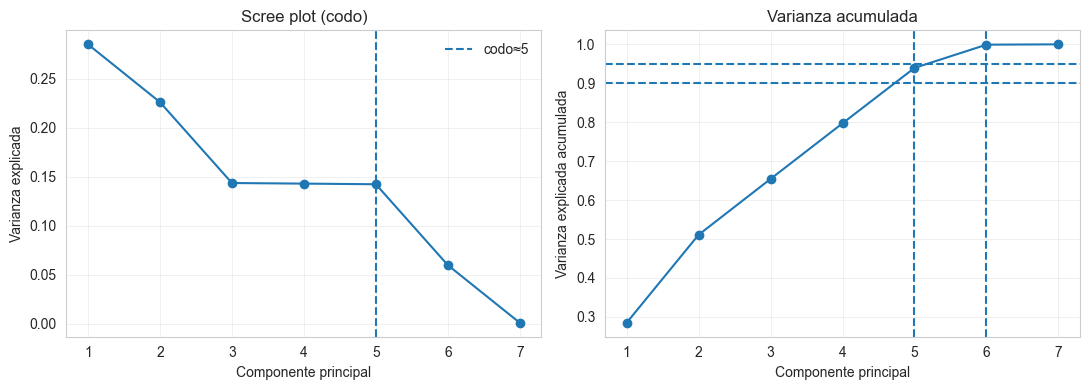

In [17]:
# --------- Gráficos ----------
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# (a) Scree / codo
axs[0].plot(ks, expl, marker="o")
axs[0].set_xlabel("Componente principal")
axs[0].set_ylabel("Varianza explicada")
axs[0].set_title("Scree plot (codo)")
axs[0].grid(True, linewidth=0.4, alpha=0.5)
axs[0].axvline(k_elbow, linestyle="--", label=f"codo≈{k_elbow}")
axs[0].legend(frameon=False)

# (b) Acumulada con líneas de referencia
axs[1].plot(ks, cum, marker="o")
axs[1].set_xlabel("Componente principal")
axs[1].set_ylabel("Varianza explicada acumulada")
axs[1].set_title("Varianza acumulada")
axs[1].grid(True, linewidth=0.4, alpha=0.5)
axs[1].axhline(0.90, linestyle="--"); axs[1].axvline(k90, linestyle="--")
axs[1].axhline(0.95, linestyle="--"); axs[1].axvline(k95, linestyle="--")

plt.tight_layout(); plt.show()

In [18]:
# Elige el número de componentes (puedes usar 0.95 para varianza acumulada)

###############################################
# El codo en 5 toma el 94% y el codo en 6 el 99%, por lo tanto, escogemos el codo en 5
k = 5
###############################################

pca_pipe = Pipeline(steps=[
    ("pre", preprocessor_num),         # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()), # re-estandarización para usar correlaciones
    ("pca", PCA(n_components=k, svd_solver="full", random_state=0)),

])

# --- FIT en train ---
pca_pipe.fit(X_train_num)

# --- TRANSFORM en train y test ---
T_train = pca_pipe.transform(X_train_num)
T_test  = pca_pipe.transform(X_test_num)

# DataFrames de scores
pc_cols = [f"PC{i+1}" for i in range(T_train.shape[1])]
T_train_df = pd.DataFrame(T_train, columns=pc_cols, index=X_train_num.index)
T_test_df  = pd.DataFrame(T_test,  columns=pc_cols, index=X_test_num.index)

# Varianza explicada
pca_step = pca_pipe.named_steps["pca"]
expl = pca_step.explained_variance_ratio_
eigenvalues = pca_step.explained_variance_
print("Eigenvalores:", eigenvalues)

print("Varianza explicada:", np.round(expl, 6))
print("Acumulada:", np.round(np.cumsum(expl), 6))

# Guardar outputs (opcional)
T_train_df.to_csv("T_train_PCA.csv", index=False)
T_test_df.to_csv("T_test_PCA.csv", index=False)

print("Shapes -> T_train:", T_train_df.shape, "| T_test:", T_test_df.shape)
display(T_train_df.head(10))

Eigenvalores: [1.99454925 1.58167473 1.00425723 1.00000511 0.99546094]
Varianza explicada: [0.28493  0.225949 0.143463 0.142855 0.142206]
Acumulada: [0.28493  0.51088  0.654343 0.797198 0.939404]
Shapes -> T_train: (54750, 5) | T_test: (18250, 5)


,PC1,PC2,PC3,PC4,PC5
17384,1.563763,-0.306693,-0.784309,0.749935,-0.468179
16914,-0.977286,0.158942,-0.363401,-1.583996,-0.947575
69115,2.077495,-0.052351,0.773663,-0.457496,1.456466
37744,0.868580,-1.361134,1.086139,0.435826,-0.971959
1480,-0.764250,2.398019,-2.138291,0.620135,-0.218266
37279,1.957984,-0.937821,-0.393279,-0.613452,0.469646
41693,1.799061,-1.142941,-0.253585,-0.611188,0.617553
62578,1.190127,0.562372,1.685430,-0.882142,0.128878
12803,-0.823191,0.347318,0.370592,-0.401803,-1.927372
36816,2.195753,-1.462394,-0.271019,0.574197,0.310699


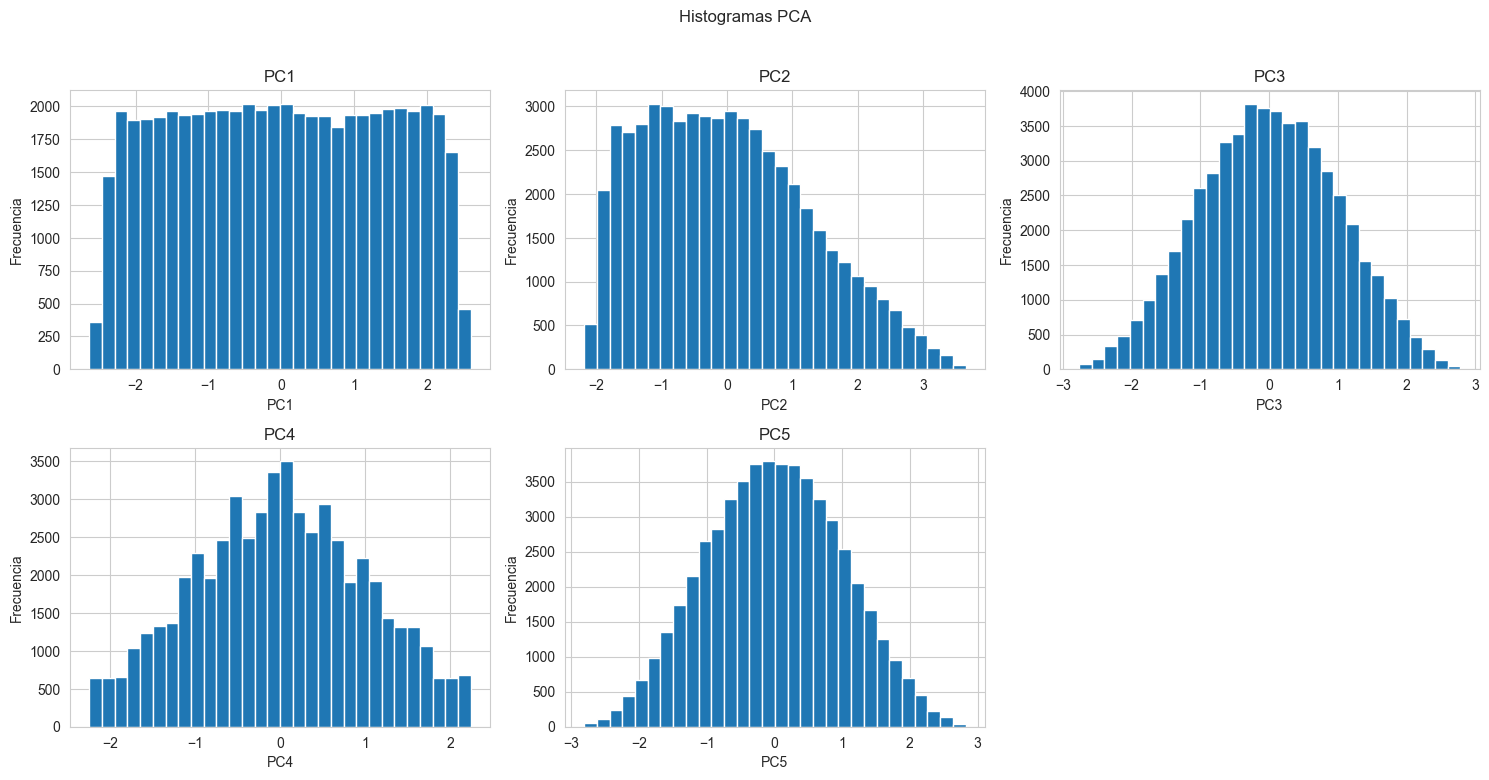

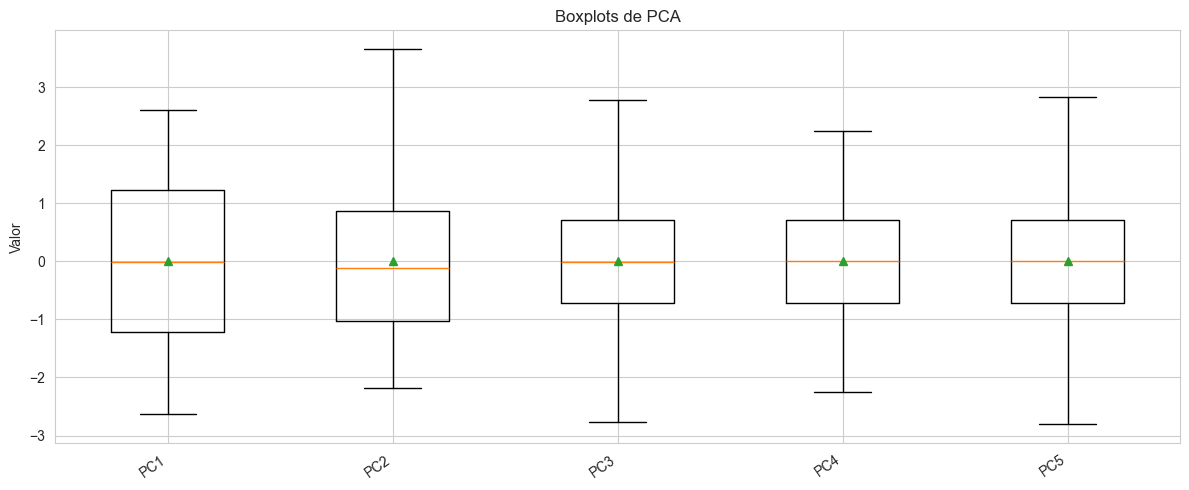

In [19]:
cols_num = ['PC1','PC2', 'PC3', 'PC4', 'PC5']

if len(cols_num) == 0:
    print("No hay columnas numéricas en X_train. No se generan imágenes.")
else:
    # --------- Figura 1: HISTOGRAMAS (todos en subplots) ----------
    n = len(cols_num)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols_num):
        s = pd.to_numeric(T_train_df[col], errors="coerce").dropna()
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.hist(s, bins=30)
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")

    # Oculta subplots sobrantes
    for j in range(len(cols_num), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas PCA", y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig("scaled_histogramas_pca.png", dpi=150, bbox_inches="tight")
   # plt.close(fig)

    # --------- Figura 2: BOXPLOTS (todas en un eje) ----------
    series_pairs = []
    for c in cols_num:
        v = pd.to_numeric(T_train_df[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos numéricos válidos para boxplots. No se genera boxplot.")
        box_path = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6*len(labels)+4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots de PCA")
        plt.tight_layout()
        fig2.savefig("scaled_boxplots_pca.png", dpi=150, bbox_inches="tight")

for c in cols_num:
    s = pd.to_numeric(T_train_df[c], errors="coerce")
    miss_pct = s.isna().mean() * 100
    s_no_na = s.dropna()
    skew = s_no_na.skew() if s_no_na.size > 1 else np.nan
    kurt = s_no_na.kurt() if s_no_na.size > 1 else np.nan
    n_out, prop_out, q1, q3, li, ls = iqr_outlier_stats(s)
    bounded_guess(s)

In [25]:
# Solo si k >= 2
import plotly.express as px

df_plot2 = T_train_df.iloc[:, :2].copy()
df_plot2["objetivo"] = y_train.loc[T_train_df.index].astype(str)
fig2 = px.scatter(df_plot2, x="PC1", y="PC2", color="objetivo",
                  opacity=0.85, title="PC1 vs PC2 por 'objetivo' (train)", height=550)
fig2.update_traces(marker=dict(size=6))
fig2.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig2.show()

ValueError: 
    Invalid value of type 'builtins.str' received for the 'hovermode' property of layout
        Received value: 'skip'

    The 'hovermode' property is an enumeration that may be specified as:
      - One of the following enumeration values:
            ['x', 'y', 'closest', False, 'x unified', 'y unified']

Reprentavidad de dos componentes (58% de todos los datos)

In [21]:
#### Solo si k>=3
df_plot = T_train_df.iloc[:, :3].copy()          # PC1, PC2, PC3
# Alinea objetivo con los índices de T_train_df
df_plot["objetivo"] = y_train.loc[T_train_df.index].astype(str)

fig = px.scatter_3d(
    df_plot,
    x="PC1", y="PC2", z="PC3",
    color="objetivo",
    opacity=0.85,
    title="PC1–PC2–PC3 por ‘objetivo’ (train)",
    height=600
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"))
fig.show()

KeyboardInterrupt: 

# Final stage

In [66]:
# === Concatenar PCs (numéricas) con categóricas codificadas ===
# Asegura alineación por índice
df_train_cat_encode = df_train_cat_encode.reindex(T_train_df.index)
df_test_cat_encode  = df_test_cat_encode.reindex(T_test_df.index)

T_train_final = pd.concat([T_train_df, df_train_cat_encode], axis=1)
T_test_final  = pd.concat([T_test_df,  df_test_cat_encode], axis=1)

# Añadir columna objetivo (alineada por índice)
T_train_final_out = T_train_final.copy()
T_test_final_out  = T_test_final.copy()

T_train_final_out["objetivo"] = y_train.loc[T_train_final.index].astype(str)
T_test_final_out["objetivo"]  = y_test.loc[T_test_final.index].astype(str)


print("T_train_final:", T_train_final.shape)
print("T_test_final :", T_test_final.shape)

T_train_final.to_csv("T_train_final.csv", index=False)
T_test_final.to_csv("T_test_final.csv", index=False)
T_train_final_out.to_csv("T_train_final_objetivo.csv", index=False)
T_test_final_out.to_csv("T_test_final_objetivo.csv", index=False)
# X_train_final.head()

T_train_final: (54750, 20)
T_test_final : (18250, 20)


In [67]:
T_train_final_out

,PC1,PC2,PC3,PC4,PC5,Category___clothing,Category___electronics,Category___furniture,Category___groceries,Category___toys,...,Region___north,Region___south,Region___west,Holiday/Promotion___0,Holiday/Promotion___1,Seasonality___autumn,Seasonality___spring,Seasonality___summer,Seasonality___winter,objetivo
17384,1.563763,-0.306693,-0.784309,0.749935,-0.468179,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,62.58
16914,-0.977286,0.158942,-0.363401,-1.583996,-0.947575,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,165.4
69115,2.077495,-0.052351,0.773663,-0.457496,1.456466,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,139.73
37744,0.868580,-1.361134,1.086139,0.435826,-0.971959,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,16.28
1480,-0.764250,2.398019,-2.138291,0.620135,-0.218266,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,319.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,0.757010,-0.706724,0.039007,0.735631,-1.038881,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,34.21
45891,-2.100000,1.759185,-0.131813,0.405219,0.734151,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,315.57
42613,-1.953110,-1.240079,0.938267,0.064447,-0.561447,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,89.52
43567,2.019405,-1.178512,0.410218,1.199747,0.097187,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,59.49


Guardar en binarios


In [68]:
# === Guardar artefactos ===
import joblib
import json

# 1) Pipelines ya FIT: preprocessor_cat y pca_pipe
joblib.dump(preprocessor_cat, "preprocessor_cat.joblib")
joblib.dump(pca_pipe, "pca_pipe_num.joblib")   # (preprocessor_num + StdScaler + PCA)

# 2) Metadatos útiles para producción
meta = {
    "cols_num": cols_num,            # columnas numéricas originales
    "cols_cat": cols_cat,            # columnas categóricas originales
    "pc_cols": list(T_train_df.columns),            # nombres de PCs (PC1, PC2, …)
    "cat_out_cols": list(df_train_cat_encode.columns)  # columnas codificadas finales (OHE + Ordinal)
}
with open("pca_metadata.json", "w") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

Se eligen 5 columnas. Las cuales se estandarizaron

In [69]:
import os, zipfile, glob
# Guardamos los calculos y el proceso de los calculos
# Carpeta destino en tu PC
dst_dir = r"mi_pca"
os.makedirs(dst_dir, exist_ok=True)
zip_path = os.path.join(dst_dir, "pca_artifacts_bundle.zip")

# Archivos que quieres incluir (ajusta si te falta alguno)
candidates = [
    "T_test_PCA.csv",
    "T_test_final.csv",
    "T_test_final_objetivo.csv",
    "T_train_PCA.csv",
    "T_train_final.csv",
    "T_train_final_objetivo.csv",
    "boxplots_numericas.png",
    "histogramas_numericas.png",
    "pca_metadata.json",
    "pca_pipe_num.joblib",
    "preprocessor_cat.joblib"
]

present = [f for f in candidates if os.path.exists(f)]
# Si quieres incluir una carpeta (p. ej., 'sample_data'), descomenta:
# for root, _, files in os.walk("sample_data"):
#     for f in files:
#         present.append(os.path.join(root, f))

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for f in present:
        zf.write(f, arcname=os.path.basename(f))  # guarda sin subcarpetas

print("ZIP creado en:", zip_path)
print("Incluidos:", present)

ZIP creado en: mi_pca\pca_artifacts_bundle.zip
Incluidos: ['T_test_PCA.csv', 'T_test_final.csv', 'T_test_final_objetivo.csv', 'T_train_PCA.csv', 'T_train_final.csv', 'T_train_final_objetivo.csv', 'boxplots_numericas.png', 'histogramas_numericas.png', 'pca_metadata.json', 'pca_pipe_num.joblib', 'preprocessor_cat.joblib']
